# State of Scripts
In this notebook,
* **scripts** refer to writing systems ([see list of scripts with ISO 154924 codes here](https://en.wikipedia.org/wiki/ISO_15924#List_of_codes))
* **projects** refer to [Wikimedia content projects](https://meta.wikimedia.org/wiki/Wikimedia_projects) with linguistic editions: Wikibooks, Wikinews, Wikipedia, Wikiquote, Wikisource, Wikiversity, Wikivoyage, and Wiktionary;
* **hosted projects** refer to projects (as defined above) that have their own domain hosted by the Wikimedia Foundation;
* **test projects** refer to pre-hosted projects located in Wikimedia Incubator (for Wikibooks, Wikinews, Wikipedia, Wikiquote, Wikivoyage, and Wiktionary), Wikiversity Beta, or Multilingual Wikisource.

In [1]:
# Packages
pacman::p_load(tidyverse, here, matrixStats, kableExtra, pollster, ggrepel, jsonlite, reticulate)

In [2]:
# Projects
proj_import <- read_tsv(here("03_wrangled_data/projects.tsv"), show_col_types=F)

# Wikimedia scripts
script_import <- read_tsv(here("02_wrangling_scripts/temp_outputs/scripts.tsv"), show_col_types=F)

In [3]:
script_import %>% filter(language_code == 'simple')

language_code iso_15924_code iso_formal_name Directionality
1 simple        Latn           Latin           left-to-right

## Which scripts do our hosted projects use?

In [4]:
## Filter projs for hosted projects
projs <- proj_import %>% filter(`test-host` == "hosted") %>%
 select(prefix, language_name, project, lang_code)

## Hand correct language ncodes for joining
## 2024-11-25 update: No longer need to run these because these codes are now available in the original file and script_import df
#script_import_updated <- rbind(script_import %>% mutate(what="original"),
#                                              script_import %>% filter(language_code=="lzh"|
#                                                                        language_code=="bho"|
#                                                                        language_code=="cbk"|
#                                                                        language_code=="en") %>%
#                                                                        mutate(what="new")
#                                             )
#
#script_import_updated$language_code[script_import_updated$language_code=="lzh" & 
#                                    script_import_updated$what=="new"] <- "zh-classical"
#script_import_updated$language_code[script_import_updated$language_code=="bho" & 
#                                    script_import_updated$what=="new"] <- "bh"
#script_import_updated$language_code[script_import_updated$language_code=="cbk" & 
#                                    script_import_updated$what=="new"] <- "cbk-zam"
#script_import_updated$language_code[script_import_updated$language_code=="en" & 
#                                    script_import_updated$what=="new"] <- "simple"

script_import_updated <- script_import

In [5]:
# Join 
joined <- projs %>%
 left_join(., script_import_updated, by = c("lang_code"="language_code"))

# Check for NAs
print(joined %>% filter(is.na(iso_15924_code)))

# A tibble: 0 × 7
# ℹ 7 variables: prefix <chr>, language_name <chr>, project <chr>,
#   lang_code <chr>, iso_15924_code <chr>, iso_formal_name <chr>,
#   Directionality <chr>


Output the list

In [6]:
write_csv(joined %>% arrange(project, language_name), here("04_analysis/outputs/scripts_hosted_projects.csv"))

Visualize

In [7]:
# How many different scripts?
length(unique(joined$iso_formal_name))

# List the scripts
unique(joined$iso_formal_name)

[1] 37

[1] "Cyrillic"                                      
 [2] "Latin"                                         
 [3] "Ethiopic (Geʻez)"                              
 [4] "Devanagari (Nagari)"                           
 [5] "Arabic"                                        
 [6] "Syriac"                                        
 [7] "Bengali (Bangla)"                              
 [8] "Myanmar (Burmese)"                             
 [9] "Tibetan"                                       
[10] "Cherokee"                                      
[11] "Unified Canadian Aboriginal Syllabics"         
[12] "Thaana"                                        
[13] "Greek"                                         
[14] "Han (Traditional variant)"                     
[15] "Gothic"                                        
[16] "Gujarati"                                      
[17] "Hebrew"                                        
[18] "Armenian"                                      
[19] "Japanese (alias for Han + Hiragana + Katakana)"
[20] "Georgian (Mkhedruli and Mtavruli)"             
[21] "Khmer"                                         
[22] "Kannada"                                       
[23] "Korean (alias for Hangul + Han)"               
[24] "Lao"                                           
[25] "Malayalam"                                     
[26] "Meitei Mayek (Meithei, Meetei)"                
[27] "N’Ko"                                          
[28] "Oriya (Odia)"                                  
[29] "Gurmukhi"                                      
[30] "Ol Chiki (Ol Cemet’, Ol, Santali)"             
[31] "Sinhala"                                       
[32] "Tamil"                                         
[33] "Tai Le"                                        
[34] "Telugu"                                        
[35] "Thai"                                          
[36] "Han (Hanzi, Kanji, Hanja)"                     
[37] "Tifinagh (Berber)"

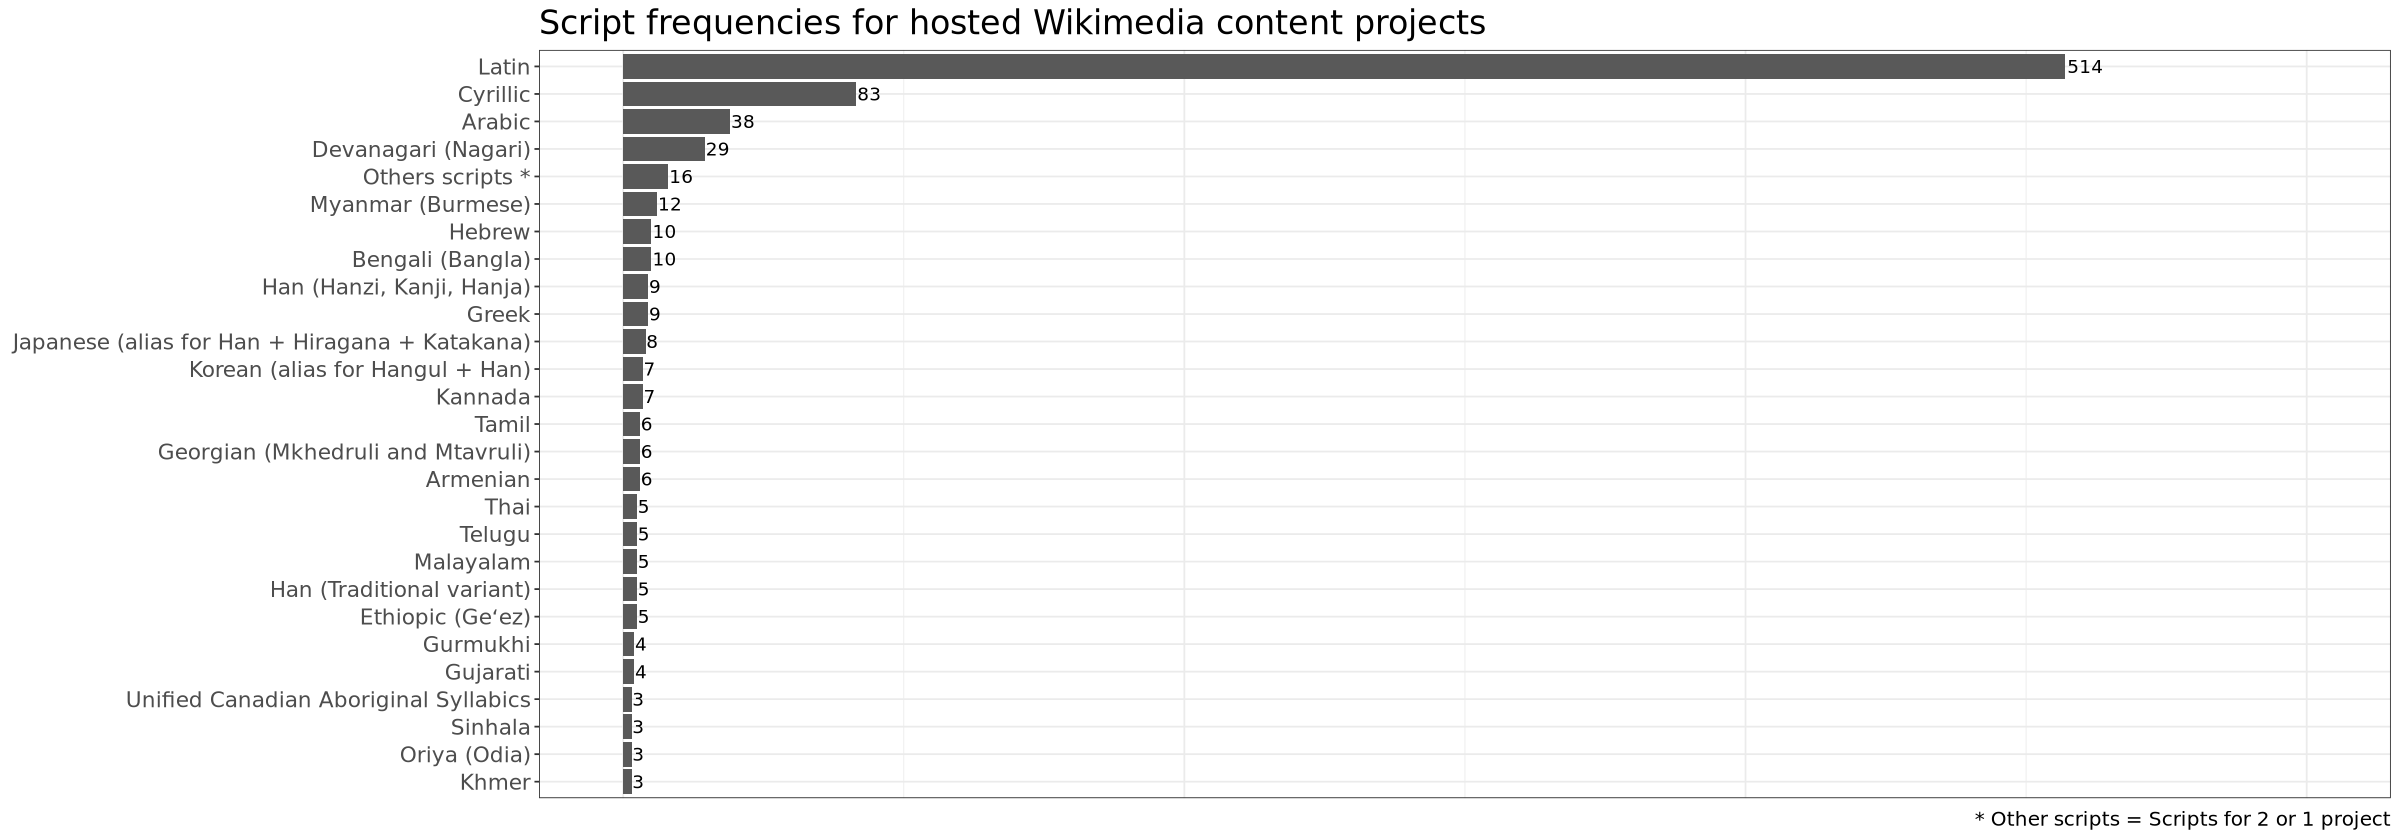

In [8]:
# Visualize frequencies
# with scripts represented by 2 or 1 project aggregated into "other"

options(dplyr.summarise.inform = FALSE)
options(repr.plot.width=20, repr.plot.height=7) 

joined %>%
 select(iso_formal_name) %>%
 mutate(count=1) %>%
 group_by(iso_formal_name) %>%
 summarise(sum_count=sum(count)) %>%
 ungroup() %>%
 mutate(iso_agg = ifelse(sum_count<3, 'Others scripts *', iso_formal_name)) %>%
 group_by(iso_agg) %>%
 summarise(sum_count_agg=sum(sum_count)) %>%
 ungroup() %>%
ggplot(aes(x=reorder(iso_agg,sum_count_agg), y=sum_count_agg, label=sum_count_agg)) +
 geom_bar(stat="identity") + 
 geom_text(hjust=-0.05) +
 coord_flip() +
 theme_bw() +
 theme(axis.text.y = element_text(size=13), axis.title = element_blank(), strip.text = element_text(size = 16),
       axis.text.x = element_blank(), axis.ticks.x = element_blank(), legend.position="none", 
       plot.title = element_text(size=20), plot.caption = element_text(size=12)) +
 #scale_x_discrete(labels = function(x) str_wrap(x, width = 35)) +
 ylim(0, 600) +
 labs(title="Script frequencies for hosted Wikimedia content projects", caption="* Other scripts = Scripts for 2 or 1 project")

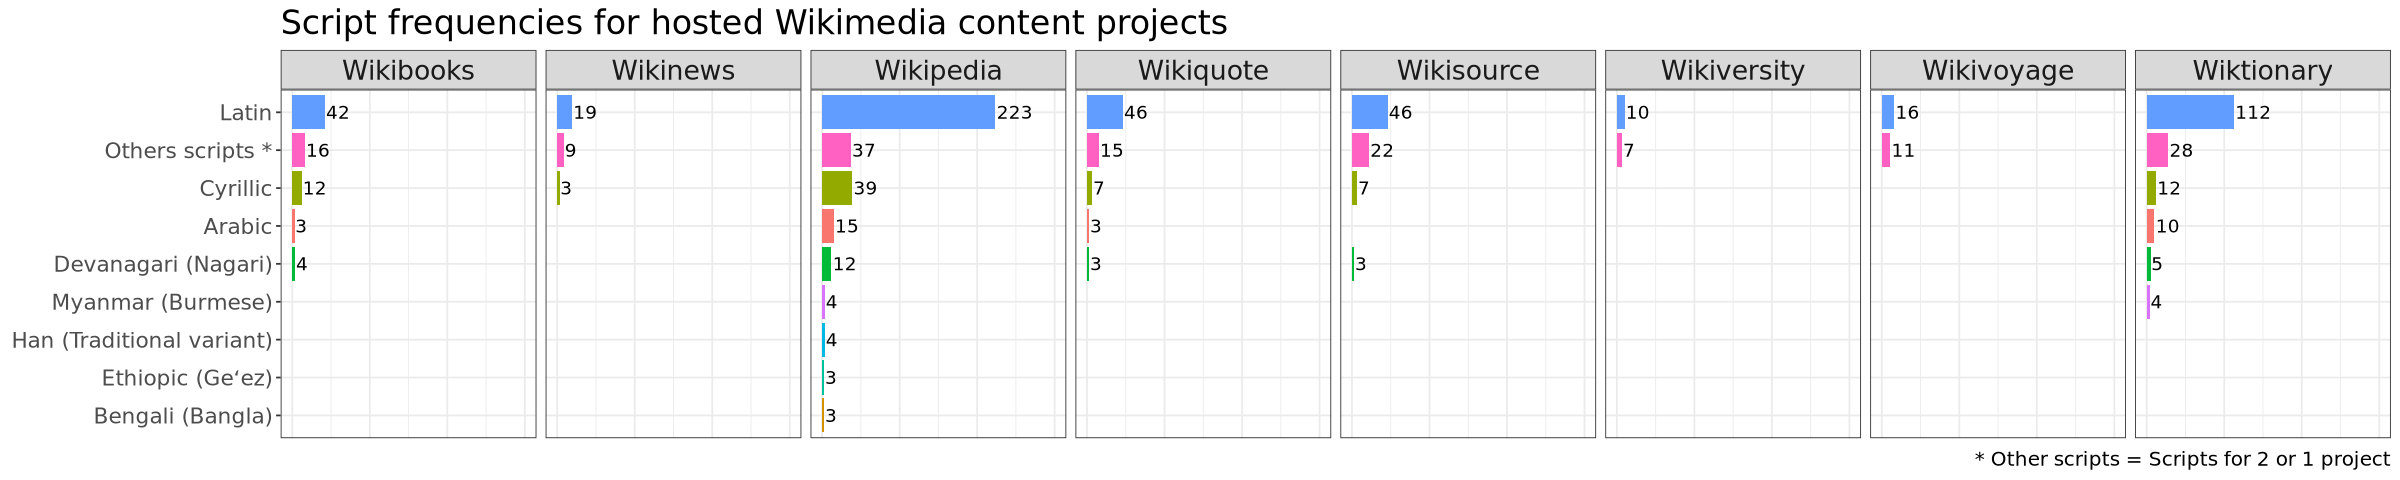

In [9]:
# Visualize frequencies per project
# with scripts represented by 2 or 1 project aggregated into "other"

options(dplyr.summarise.inform = FALSE)
options(repr.plot.width=20, repr.plot.height=4) 

joined %>%
 select(iso_formal_name, project) %>%
 mutate(count=1) %>%
 group_by(iso_formal_name, project) %>%
 summarise(sum_count=sum(count)) %>%
 ungroup() %>%
 mutate(iso_agg = ifelse(sum_count<3, 'Others scripts *', iso_formal_name)) %>%
 group_by(iso_agg, project) %>%
 summarise(sum_count_agg=sum(sum_count)) %>%
 ungroup() %>%
ggplot(aes(x=reorder(iso_agg,sum_count_agg), y=sum_count_agg, label=sum_count_agg)) +
 geom_bar(stat="identity", aes(fill=iso_agg)) + 
 geom_text(hjust=-0.05) +
 facet_wrap(.~project, ncol=8) +
 coord_flip() +
 theme_bw() +
 theme(axis.text.y = element_text(size=13), axis.title = element_blank(), strip.text = element_text(size = 16),
       axis.text.x = element_blank(), axis.ticks.x = element_blank(), legend.position="none", 
       plot.title = element_text(size=20), plot.caption = element_text(size=12)) +
 scale_x_discrete(labels = function(x) str_wrap(x, width = 35)) +
 ylim(0, 300) +
 labs(title="Script frequencies for hosted Wikimedia content projects, by project type")+
 labs(title="Script frequencies for hosted Wikimedia content projects", caption="* Other scripts = Scripts for 2 or 1 project")